In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from collections import defaultdict
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [4]:
%cd /Users/rainieday/Desktop/archive

/Users/rainieday/Desktop/archive


In [5]:
df_test = pd.read_csv('aug_test.csv')
df_train = pd.read_csv('aug_train.csv')
df_test_target = pd.read_csv('sample_submission.csv')

In [6]:
#importance of join
#df_train_comb = pd.merge(df_test,df_test_target, on = 'enrollee_id', how = 'inner')
df = df_train
df_raw = df.copy()
df.shape

(19158, 14)

In [7]:
####City

In [8]:
for x in df.columns:
    print('----COLUMNS----',x)
    print(df[x].dtype)
    print(df[x].unique().tolist()[:20])

----COLUMNS---- enrollee_id
int64
[8949, 29725, 11561, 33241, 666, 21651, 28806, 402, 27107, 699, 29452, 23853, 25619, 5826, 8722, 6588, 4167, 5764, 2156, 11399]
----COLUMNS---- city
object
['city_103', 'city_40', 'city_21', 'city_115', 'city_162', 'city_176', 'city_160', 'city_46', 'city_61', 'city_114', 'city_13', 'city_159', 'city_102', 'city_67', 'city_100', 'city_16', 'city_71', 'city_104', 'city_64', 'city_101']
----COLUMNS---- city_development_index
float64
[0.92, 0.7759999999999999, 0.624, 0.789, 0.767, 0.764, 0.762, 0.913, 0.926, 0.8270000000000001, 0.843, 0.804, 0.855, 0.887, 0.91, 0.884, 0.924, 0.6659999999999999, 0.5579999999999999, 0.923]
----COLUMNS---- gender
object
['Male', nan, 'Female', 'Other']
----COLUMNS---- relevent_experience
object
['Has relevent experience', 'No relevent experience']
----COLUMNS---- enrolled_university
object
['no_enrollment', 'Full time course', nan, 'Part time course']
----COLUMNS---- education_level
object
['Graduate', 'Masters', 'High Schoo

#### Explore and identify preprocessing steps

In [9]:
#missing values per column
df.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [10]:
#Missing values per row
missing_value_row=pd.DataFrame(df.isnull().sum(axis=1))
missing_value_row[0].value_counts()

0    8955
1    3718
2    3654
3    1953
4     628
5     176
6      62
7      12
Name: 0, dtype: int64

In [11]:
#examine the rows that have too many missing values
missing_value_row[missing_value_row[0]==7]

,0
1376,7
2518,7
7746,7
8905,7
9206,7
10337,7
11789,7
12079,7
12348,7
13236,7


In [12]:
#drop the missing values
df.dropna(axis=0,thresh=10,inplace=True)

In [13]:
df.shape

(18908, 14)

#### City

In [14]:
city_dict = df['city'].value_counts().to_dict()

In [15]:
##Binning, catigorize all counts of candidates<=50 as one group "small city"
lst_small_city=[]
lst_mid_city=[]
lst_large_city=[]
lst_superlarge_city=[]
for key,value in city_dict.items():
  if value <= 50:
    lst_small_city.append(key)
  if value > 50 and value <=100:
    lst_mid_city.append(key)
  if value > 100 and value <=200:
    lst_large_city.append(key)
  else:
    lst_superlarge_city.append(key)

In [16]:
#replace those small city names to "city_small"

df.loc[df['city'].isin(lst_small_city),'city'] = 'city_small'
df.loc[df['city'].isin(lst_mid_city),'city'] = 'city_mid'
df.loc[df['city'].isin(lst_large_city),'city'] = 'city_large'
df.loc[df['city'].isin(lst_superlarge_city),'city'] = 'city_superlarge'
df.city.value_counts()

city_superlarge    13615
city_large          2566
city_mid            1457
city_small          1270
Name: city, dtype: int64

In [17]:
le = LabelEncoder().fit(df['city'])
CityList = le.classes_
df['city'] = le.transform(df['city']) 
#keep the record of labeling
dict(zip(le.classes_,le.transform(le.classes_)))

{'city_large': 0, 'city_mid': 1, 'city_small': 2, 'city_superlarge': 3}

#### City_development_index

<AxesSubplot:xlabel='city_development_index'>

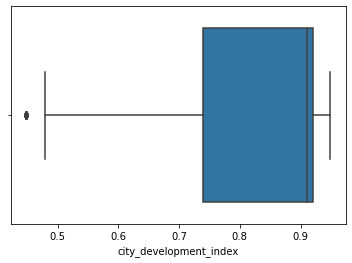

In [18]:
#Check outliers, needs for normalization
sns.boxplot(x=df['city_development_index'])

In [19]:
#List all the outliers
q1 = np.quantile(df['city_development_index'],0.25)
q3 = np.quantile(df['city_development_index'],0.75)
iqr = q3 - q1
upperbound = q3+(1.5*iqr)
lowerbound = q1-(1.5*iqr)
print(iqr, upperbound, lowerbound)

0.18000000000000005 1.1900000000000002 0.4699999999999999


In [20]:
df['city_development_index']

0        0.920
1        0.776
2        0.624
3        0.789
4        0.767
         ...  
19153    0.878
19154    0.920
19155    0.920
19156    0.802
19157    0.855
Name: city_development_index, Length: 18908, dtype: float64

In [21]:
df.loc[(df['city_development_index']<=lowerbound)|(df['city_development_index']>=upperbound)]

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
1523,8238,2,0.448,NaN,Has relevent experience,Part time course,Graduate,STEM,10,50-99,NGO,>4,48,1.0
4744,30985,2,0.448,NaN,No relevent experience,Full time course,Graduate,STEM,2,NaN,NaN,never,43,1.0
5010,27970,2,0.448,Male,No relevent experience,no_enrollment,Graduate,STEM,1,NaN,NaN,never,73,1.0
5265,31194,2,0.448,NaN,No relevent experience,NaN,High School,NaN,5,NaN,Pvt Ltd,never,86,1.0
5567,598,2,0.448,NaN,Has relevent experience,Part time course,Masters,STEM,6,NaN,NaN,1,18,1.0
6127,18564,2,0.448,NaN,No relevent experience,Full time course,Graduate,STEM,4,NaN,Public Sector,4,32,1.0
7724,31179,2,0.448,Male,Has relevent experience,no_enrollment,Graduate,STEM,7,50-99,Pvt Ltd,1,28,0.0
7864,26838,2,0.448,Male,Has relevent experience,no_enrollment,Graduate,STEM,8,NaN,NaN,>4,74,0.0
9134,4858,2,0.448,NaN,No relevent experience,Part time course,Masters,Other,2,<10,NGO,1,23,1.0
10401,19463,2,0.448,Male,No relevent experience,no_enrollment,Graduate,STEM,5,10000+,Pvt Ltd,2,36,0.0


#### Gender

In [22]:
df[df.gender.isna()]

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
2,11561,3,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,1,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
5,21651,2,0.764,NaN,Has relevent experience,Part time course,Graduate,STEM,11,NaN,NaN,1,24,1.0
9,699,3,0.920,NaN,Has relevent experience,no_enrollment,Graduate,STEM,17,10000+,Pvt Ltd,>4,123,0.0
10,29452,3,0.624,NaN,No relevent experience,Full time course,High School,NaN,2,NaN,NaN,never,32,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19140,11398,3,0.920,NaN,No relevent experience,no_enrollment,Primary School,NaN,2,NaN,NaN,never,15,0.0
19144,17191,3,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,4,NaN,NaN,never,48,1.0
19145,155,2,0.725,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,Pvt Ltd,never,190,0.0
19148,9212,3,0.624,NaN,Has relevent experience,no_enrollment,Masters,STEM,3,100-500,Pvt Ltd,3,40,1.0


<AxesSubplot:xlabel='enrolled_university,education_level,major_discipline'>

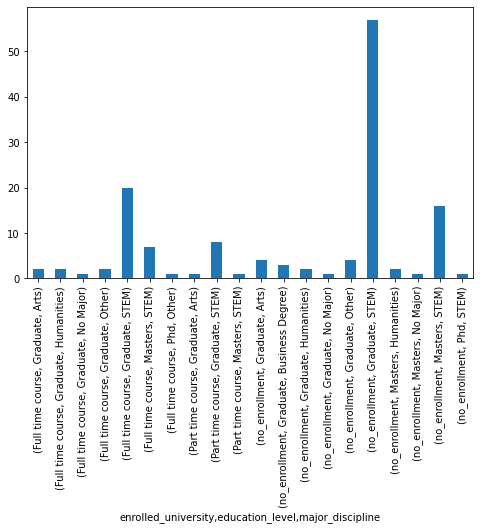

In [23]:
#Check 'other' distribution on enrolled_university, education_level, major_discipline
group = df[df['gender'] =='Other'].groupby(['enrolled_university', 'education_level', 'major_discipline']).size()
figure(figsize=(8,5))
group.plot.bar()

<AxesSubplot:xlabel='enrolled_university,education_level,major_discipline'>

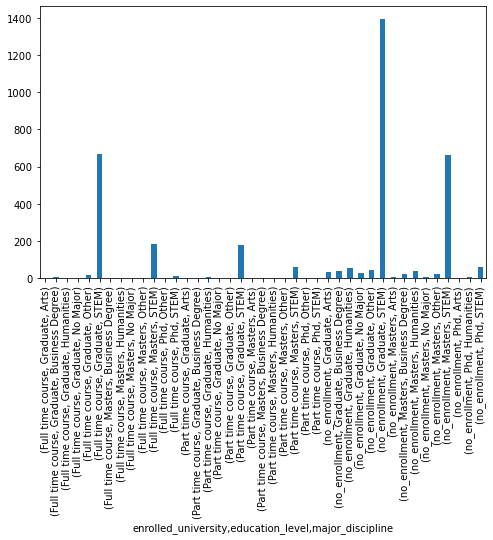

In [24]:
#Check 'na' distribution on enrolled_university, education_level, major_discipline

group = df[df['gender'].isna()].groupby(['enrolled_university', 'education_level', 'major_discipline']).size()
figure(figsize=(8,5))
group.plot.bar()

<AxesSubplot:>

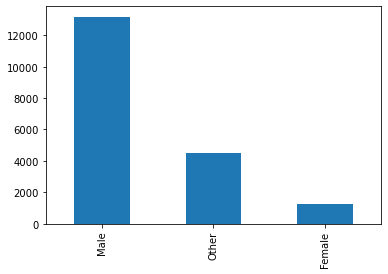

In [25]:
#replace the null value of gender to 'other'
df['gender'].fillna('Other', inplace=True)
df['gender'].value_counts().plot(kind='bar')

In [26]:
gender_ohe=pd.get_dummies(df.gender,prefix='gender')
#merge one-hot encoded columns back with original DF
df = df.loc[:, df.columns != 'gender'].join(gender_ohe)

#### relevant_experience

In [27]:
#convert to binary
df.relevent_experience.value_counts(dropna=False)

Has relevent experience    13734
No relevent experience      5174
Name: relevent_experience, dtype: int64

In [28]:
le = preprocessing.LabelEncoder()
df['relevent_experience'] = le.fit_transform(df['relevent_experience'])

In [29]:
#labelencoding reference
le.classes_
dict(zip(le.classes_, le.transform(le.classes_)))

{'Has relevent experience': 0, 'No relevent experience': 1}

In [30]:
df

,enrollee_id,city,city_development_index,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target,gender_Female,gender_Male,gender_Other
0,8949,3,0.920,0,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0,0,1,0
1,29725,1,0.776,1,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0,0,1,0
2,11561,3,0.624,1,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0,0,0,1
3,33241,1,0.789,1,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0,0,0,1
4,666,0,0.767,0,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,0,0.878,1,no_enrollment,Graduate,Humanities,14,NaN,NaN,1,42,1.0,0,1,0
19154,31398,3,0.920,0,no_enrollment,Graduate,STEM,14,NaN,NaN,4,52,1.0,0,1,0
19155,24576,3,0.920,0,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,4,44,0.0,0,1,0
19156,5756,0,0.802,0,no_enrollment,High School,NaN,<1,500-999,Pvt Ltd,2,97,0.0,0,1,0


#### enrolled_university

In [31]:
df['enrolled_university'].fillna('Unknown', inplace = True)
df.enrolled_university.value_counts(dropna=False, normalize=True)

no_enrollment       0.726095
Full time course    0.196689
Part time course    0.062883
Unknown             0.014333
Name: enrolled_university, dtype: float64

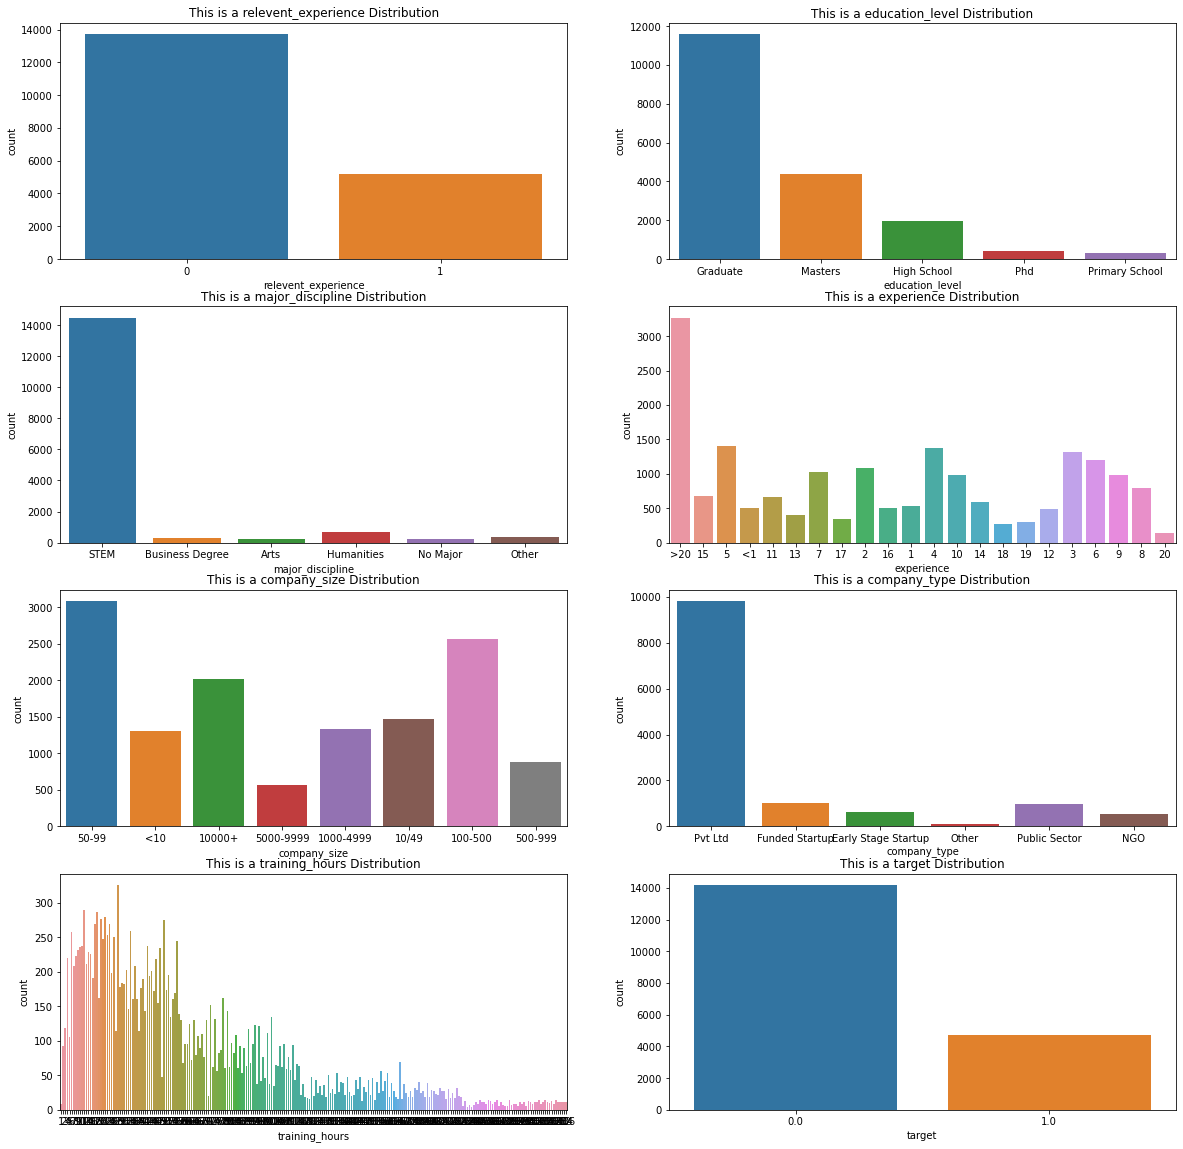

In [32]:
col = ['relevent_experience','education_level','major_discipline','experience','company_size','company_type',
       'training_hours','target']
plt.figure(figsize=[20,20])
n=1
for col_name in col:
    plt.subplot(4,2,n)
    sns.countplot(x=col_name, data=df)
    plt.title(f"This is a {col_name} Distribution")
    n=n+1

plt.show()

In [33]:
le_enrolled_university = LabelEncoder().fit(df['enrolled_university'])
df['enrolled_university']=le_enrolled_university.transform(df['enrolled_university'])
dict(zip(le_enrolled_university.classes_,le_enrolled_university.transform(le_enrolled_university.classes_)))

{'Full time course': 0,
 'Part time course': 1,
 'Unknown': 2,
 'no_enrollment': 3}

<AxesSubplot:xlabel='enrolled_university', ylabel='count'>

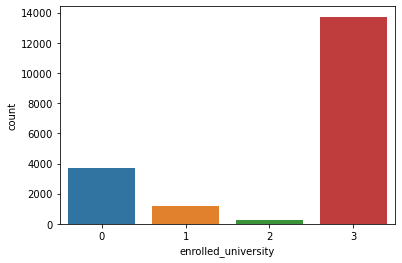

In [34]:
sns.countplot(x='enrolled_university',data=df)

#### Education_level

In [35]:
le_education_level = LabelEncoder().fit(df['education_level'])
df['education_level']=le_education_level.transform(df['education_level'])
dict(zip(le_education_level.classes_,le_education_level.transform(le_education_level.classes_)))

{'Graduate': 0,
 'High School': 1,
 'Masters': 2,
 'Phd': 3,
 'Primary School': 4,
 nan: 5}

#### major_discipline

In [36]:
df.major_discipline.value_counts(dropna=False)

STEM               14483
NaN                 2572
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
Name: major_discipline, dtype: int64

In [37]:
df['major_discipline'].fillna('other', inplace=True)

In [38]:
major_ohe = pd.get_dummies(df.major_discipline, prefix='major')
df = df.loc[:, df.columns!='major_discipline'].join(major_ohe)

#### Company_size

In [39]:
df.company_size.value_counts(dropna=False)

NaN          5695
50-99        3083
100-500      2568
10000+       2018
10/49        1469
1000-4999    1328
<10          1307
500-999       877
5000-9999     563
Name: company_size, dtype: int64

In [40]:
df['company_size'].replace(['<10','10/49','50-99','100-500','500-999','1000-4999','5000-9999','10000+'],
                           ['Startup','Small','Small','Medium','Medium','Large','Large','Large'], inplace=True)
df['company_size'] = df['company_size'].fillna(df['company_size'].value_counts().index[0])
CSLabelEncoder =LabelEncoder().fit(df['company_size'])
CSList = CSLabelEncoder.classes_
df['company_size'] =CSLabelEncoder.transform(df['company_size'])

#### Experience

In [41]:
df.experience.value_counts()

>20    3269
5      1411
4      1381
3      1321
6      1204
2      1080
7      1023
10      985
9       976
8       795
15      683
11      662
14      586
1       526
16      505
<1      498
12      491
13      398
17      341
19      303
18      278
20      146
Name: experience, dtype: int64

In [42]:
df['experience'].replace(['>20','<1'],[20,1],inplace=True)
df['experience'].fillna(df['experience'].value_counts().index[0],inplace=True)
df['experience']=[float(i)for i in df['experience']]

#### company_type

In [43]:
df.company_type.value_counts(dropna=False)

Pvt Ltd                9814
NaN                    5894
Funded Startup         1001
Public Sector           954
Early Stage Startup     603
NGO                     521
Other                   121
Name: company_type, dtype: int64

In [44]:
df['company_type'].fillna('other', inplace=True)

In [45]:
company_ohe=pd.get_dummies(df.company_type, prefix='company_type')
df = df.loc[:, df.columns!='company_type'].join(company_ohe)

#### last_new_job

In [46]:
df.last_new_job.value_counts()

1        8004
>4       3279
2        2890
never    2351
4        1028
3        1021
Name: last_new_job, dtype: int64

In [47]:
df['last_new_job'].replace(['>4','never'],['4','0'],inplace=True)
df['last_new_job'].fillna(df['last_new_job'].value_counts().index[0],inplace=True)
df['last_new_job']=[float(i)for i in df['last_new_job']]

#### Validate the Data 

In [48]:
df.dtypes

enrollee_id                           int64
city                                  int64
city_development_index              float64
relevent_experience                   int64
enrolled_university                   int64
education_level                       int64
experience                          float64
company_size                          int64
last_new_job                        float64
training_hours                        int64
target                              float64
gender_Female                         uint8
gender_Male                           uint8
gender_Other                          uint8
major_Arts                            uint8
major_Business Degree                 uint8
major_Humanities                      uint8
major_No Major                        uint8
major_Other                           uint8
major_STEM                            uint8
major_other                           uint8
company_type_Early Stage Startup      uint8
company_type_Funded Startup     

In [49]:
df.head()

,enrollee_id,city,city_development_index,relevent_experience,enrolled_university,education_level,experience,company_size,last_new_job,training_hours,...,major_Other,major_STEM,major_other,company_type_Early Stage Startup,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,company_type_other
0,8949,3,0.920,0,3,0,20.0,2,1.0,36,...,0,1,0,0,0,0,0,0,0,1
1,29725,1,0.776,1,3,0,15.0,2,4.0,47,...,0,1,0,0,0,0,0,0,1,0
2,11561,3,0.624,1,0,0,5.0,2,0.0,83,...,0,1,0,0,0,0,0,0,0,1
3,33241,1,0.789,1,2,0,1.0,2,0.0,52,...,0,0,0,0,0,0,0,0,1,0
4,666,0,0.767,0,3,2,20.0,2,4.0,8,...,0,1,0,0,1,0,0,0,0,0


In [62]:
###remove "enrollee_id" as identifier doesn't provide information to the target
df = df.loc[:, df.columns!='enrollee_id']

## Training and Testing Split

#### Random Splitting

In [63]:
from sklearn.model_selection import train_test_split
x = df.loc[:, df.columns!='target']
y = df.loc[:, df.columns=='target']
x_train_rand, x_test_rand, y_train_rand, y_test_rand = train_test_split(x,y,test_size=0.2,random_state=42,shuffle=True)

#### Stratify Splitting

In [64]:
from sklearn.model_selection import StratifiedShuffleSplit

strat = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

for train_index, test_index in strat.split(df,df['education_level']):
    strat_train = df.iloc[train_index]
    strat_test = df.iloc[test_index]

In [65]:
#compare the stratify vs random sampling from original proportions
#stratified sampling has almost close to original proportion while the random is skewed
original = pd.DataFrame(df.education_level.value_counts(normalize=True))\
                .rename(columns={'education_level':'Original'})
stratify = pd.DataFrame(df.education_level.value_counts(normalize=True))\
                .rename(columns={'education_level':'Stratify'})
random = pd.DataFrame(df.education_level.value_counts(normalize=True))\
                .rename(columns={'education_level':'Random'})
error_summary = pd.concat([original, stratify, random], axis=1)

error_summary['stratify_error%']=(error_summary['Stratify']- error_summary['Original'])/error_summary['Stratify']
error_summary['random_error%']=(error_summary['Random']- error_summary['Original'])/error_summary['Random']

error_summary

,Original,Stratify,Random,stratify_error%,random_error%
0,0.613021,0.613021,0.613021,0.0,0.0
2,0.230432,0.230432,0.230432,0.0,0.0
1,0.103818,0.103818,0.103818,0.0,0.0
3,0.021843,0.021843,0.021843,0.0,0.0
4,0.015866,0.015866,0.015866,0.0,0.0
5,0.015020,0.015020,0.015020,0.0,0.0


### Oversampling

In [72]:
print(df.target.value_counts(normalize=True))
df.target.value_counts()

0.0    0.750476
1.0    0.249524
Name: target, dtype: float64


0.0    14190
1.0     4718
Name: target, dtype: int64

In [67]:
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [74]:
from imblearn.over_sampling import SMOTE
x= df.loc[:,df.columns !='target']
y= df.loc[:,df.columns =='target']
oversample = SMOTE(random_state=42, sampling_strategy=0.6)
x_smote, y_smote = oversample.fit_resample(x,y)
oversample.get_params()

{'k_neighbors': 5,
 'n_jobs': None,
 'random_state': 42,
 'sampling_strategy': 0.6}

In [75]:
y_smote.value_counts(normalize=True)

target
0.0       0.625
1.0       0.375
dtype: float64

In [77]:
#Train and Testing split
x_train, x_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.2, random_state=42, 
                                                    shuffle=True, stratify=y_smote)
x_train.to_csv('x_train.csv', index=False)
x_test.to_csv('x_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('t_test.csv', index=False)

In [78]:
%pwd

'/Users/rainieday/Desktop/archive'

## Random Forest

In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import feature_selection
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train, y_train)

/var/folders/q7/cyzsqjd11xvf0n_4rnvmw4lh0000gn/T/ipykernel_30539/1152331699.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, y_train)


RandomForestClassifier(random_state=42)

In [80]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [82]:
#feature importance
rf.feature_importances_

array([0.03297769, 0.21909461, 0.01896162, 0.03410029, 0.03634093,
       0.12942217, 0.04086978, 0.07159026, 0.19403522, 0.01417679,
       0.01863042, 0.01989252, 0.00259268, 0.00352247, 0.00537322,
       0.00217139, 0.00357461, 0.01265587, 0.01543947, 0.00954686,
       0.01606495, 0.00971712, 0.00295341, 0.01238338, 0.04600667,
       0.02790558])

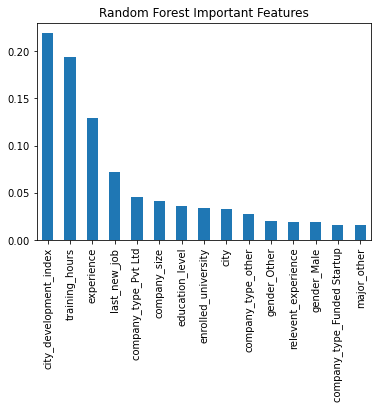

In [91]:
feat_importances = pd.Series(rf.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).plot(kind='bar')
plt.title("Random Forest Important Features")
plt.show()

In [70]:
df_raw['stratify_col']=df_raw['gender']+'_'+df_raw['target'].apply(lambda x: str(x))

In [71]:
df_raw.stratify_col.value_counts()

Male_0.0      10209
Male_1.0       3012
Female_0.0      912
Female_1.0      326
Other_0.0       141
Other_1.0        50
Name: stratify_col, dtype: int64

## Prediction

In [93]:
y_pred_rf = rf.predict(x_test)
predictions = [round(value)for value in y_pred_rf]
y_pred_rf

array([1., 0., 0., ..., 0., 0., 0.])

In [95]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predictions)
print('Accuracy: %.2f%%'%(accuracy*100.0))

Accuracy: 80.64%


In [98]:
#Create the pareameter grid based on the results of random search
from sklearn.model_selection import GridSearchCV

forest_params = [{'max_depth':[10,15,20], 'max_features':[0,5,10]}]
rfc = RandomForestClassifier()
clf = GridSearchCV(rfc, forest_params, cv=10, scoring='accuracy')
clf.fit(x_train.to_numpy(), y_train.to_numpy().ravel())

print(clf.best_params_)
print(clf.best_score_)

/Users/rainieday/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rainieday/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rainieday/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 476, in fit
    trees = Parallel(
  File "/Users/rainieday/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(

{'max_depth': 15, 'max_features': 10}
0.8112649984604532


In [99]:
rf_2 = RandomForestClassifier(random_state = 42, max_depth = 15, max_features = 5)
rf_2.fit(x_train, y_train)#train the model on training data

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:%.2f"%(accuracy*100.0))

/var/folders/q7/cyzsqjd11xvf0n_4rnvmw4lh0000gn/T/ipykernel_30539/928780060.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_2.fit(x_train, y_train)#train the model on training data


Accuracy:80.64


## XGBoost

In [69]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [100]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [101]:
y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]

In [102]:
from sklearn.metrics import accuracy_score

#evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:%.2f"%(accuracy*100.0))

Accuracy:82.12


## Model Result Evaluation

In [105]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, predictions,labels=[1,0])

array([[1263,  440],
       [ 372, 2466]])

/Users/rainieday/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


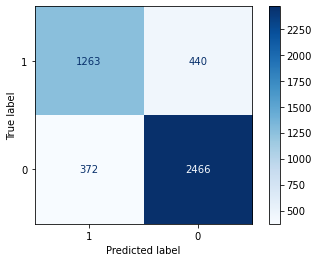

In [107]:
from sklearn.metrics import plot_confusion_matrix
color = 'white'
matrix = plot_confusion_matrix(model, x_test, y_test,cmap=plt.cm.Blues,labels=[1,0])
plt.show()

In [109]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86      2838
         1.0       0.77      0.74      0.76      1703

    accuracy                           0.82      4541
   macro avg       0.81      0.81      0.81      4541
weighted avg       0.82      0.82      0.82      4541



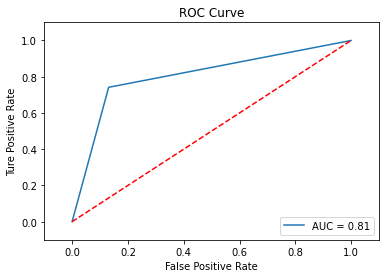

In [114]:
from sklearn import metrics
preds = y_pred
fpr, tpr, _ = metrics.roc_curve(y_test, preds)
auc_score = metrics.auc(fpr, tpr)

#clear current figure
plt.clf()

plt.title('ROC Curve')
plt.plot(fpr, tpr, label = 'AUC = {:.2f}'.format(auc_score))

plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('Ture Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()



<AxesSubplot:>

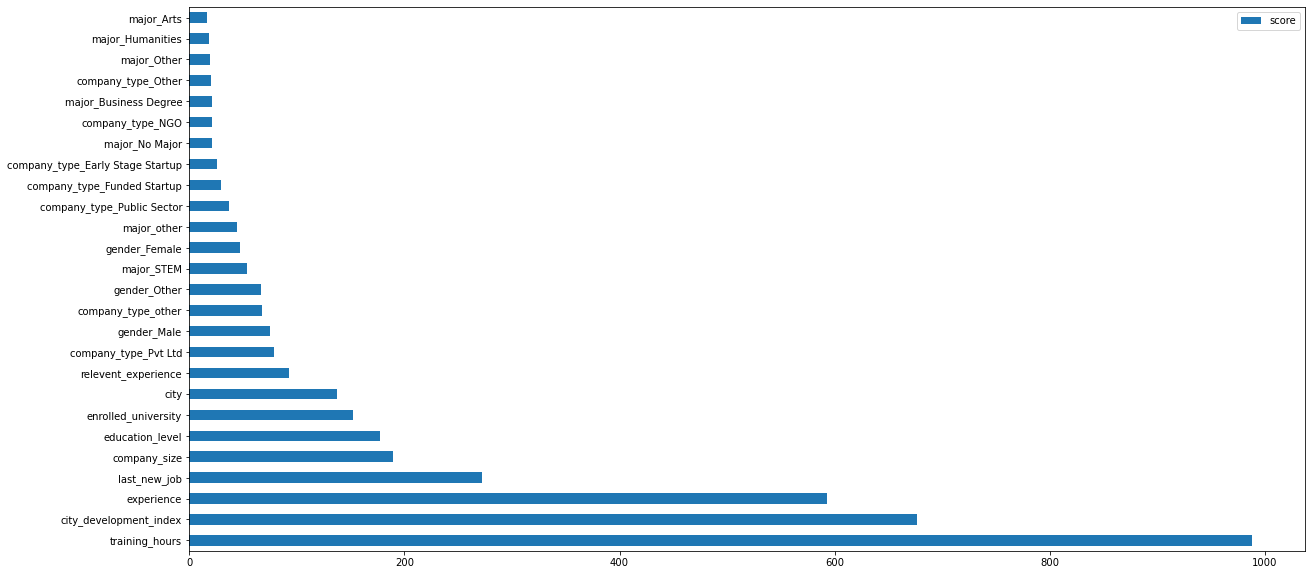

In [121]:
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data=pd.DataFrame(data=values, index=keys, columns=['score']).sort_values(by = "score", ascending=False)
data.nlargest(40, columns='score').plot(kind='barh',figsize = (20,10))

### Hyperparameter Tuning


### Shap

In [123]:
%pip install shap

     |████████████████████████████████| 436 kB 3.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [124]:
import shap
shap.initjs

<function shap.plots._force.initjs()>

In [125]:
#get shap values
explainer = shap.Explainer(model)
shap_values = explainer(x_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


### Force Plot

In [127]:
shap.plots.force(shap_values[1])
shap.plots.force(shap_values[3])

In [128]:
x_test[0:2]

,city,city_development_index,relevent_experience,enrolled_university,education_level,experience,company_size,last_new_job,training_hours,gender_Female,...,major_Other,major_STEM,major_other,company_type_Early Stage Startup,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,company_type_other
14457,2,0.647,0,3,2,6.0,3,1.0,15,0,...,0,1,0,0,0,0,0,0,1,0
4300,3,0.910,0,3,0,20.0,2,2.0,50,0,...,0,1,0,0,0,0,0,0,1,0


In [129]:
y_test[1:4]

,target
4300,0.0
14122,0.0
20578,1.0


### Beeswarm

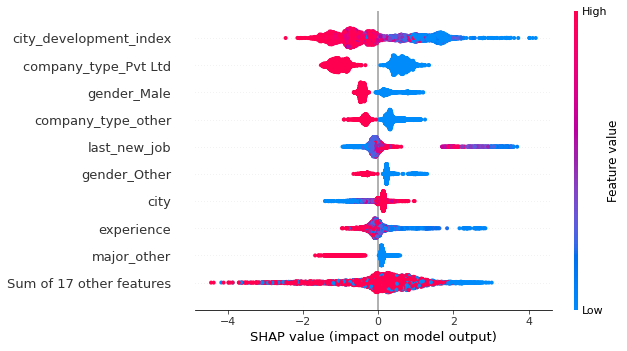

In [130]:
shap.plots.beeswarm(shap_values)

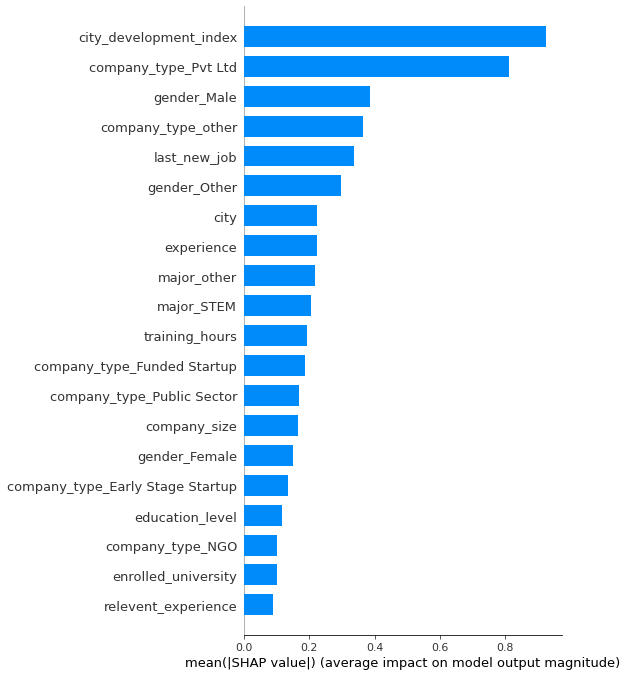

In [131]:
shap.summary_plot(shap_values, x_test, plot_type ='bar')